# Fisheries Training Part 1 - Harvest Optimization and MOEA Diagnostics
Welcome to the second post in the Fisheries Training Series, in which we are studying decision making under deep uncertainty within the context of a complex harvested predator-prey fishery. The accompanying GitHub repository, containing all of the source code used throughout this series, is available [here](https://github.com/TrevorJA/harvested_predator_prey_system_tutorial_series). The [full, in-depth Jupyter Notebook version of this post](https://github.com/TrevorJA/harvested_predator_prey_system_tutorial_series/blob/main/Part_1_MOEA_Diagnostics/Part%201%20-%20Harvest%20Optimization%20and%20MOEA%20Diagnostics.ipynb) is available in the repository as well. 

This post builds off of the initial post, [Fisheries Training 0: Exploring Predator-Prey Dynamics](https://waterprogramming.wordpress.com/2022/07/11/__trashed-3/), and presents the following:
1. A brief re-cap of the harvested predator-prey model
2. Formulation of the harvesting policy and an overview of radial basis functions (RBFs)
3. Formulation of the policy objectives
4. A simulation model for the harvested system
5. Optimization of the harvesting policy using the PyBorg MOEA
    *Installation of Platypus and PyBorg
    *Optimization problem formulation
   *Basic MOEA diagnostics

>**Note**
>\*The PyBorg MOEA used in this demonstration is derived from the Borg MOEA and may only be used with permission from its creators. Fortunately, it is freely available for academic and non-commercial use. Visit [BorgMOEA.org](http://borgmoea.org/) to request access.

Now, onto the tutorial! 

## Harvested predator-prey model

In the previous post, we introduced a modified form of the Lotka-Volterra system of ordinary differential equations (ODEs) defining predator-prey population dynamics. 

This modified version includes a non-linear predator population growth dynamic original proposed by Arditi and Akçakaya (1990), and includes a harvesting parameter, $z$. This system of equations is defined in [Hadjimichael et al. (2020)](https://www.hindawi.com/journals/complexity/2020/4170453/) as:

$$
\tag{1.0}
\frac{dx}{dt} = bx\Big(1 - \frac{x}{K}\Big) - \frac{\alpha xy}{y^m + \alpha hx} - zx
$$

$$
\frac{dy}{dt} = \frac{c\alpha xy}{y^m + \alpha hx} - dy
$$

Where $x$ is the prey population being harvested and $y$ is the predator population. Refer to [Post 0 of this series](https://waterprogramming.wordpress.com/2022/07/11/__trashed-3/) for the rest of the parameter descriptions. 

The first post provided insight into the non-linear dynamics that result from these ODEs, and how the system shifts between different basins of stability or population collapse.

The purpose of this post is to focus on the generation of _harvesting policies_ which can be operated safely in the system without causing population collapse. 

## Harvesting policy

Rather than assigning a deterministic, or specific harvest effort level for every time period, we can design an _adaptive_ policy which is a function of the current state of the system: 
$$\tag{2.0} z_t = f(\cdot) $$

The problem then becomes the optimization of the control rule, $f(\cdot)$, rather than the specific values, $z = (z_0, z_1,..., z_T)$. This process of optimizing the parameters of a state-aware control rule is referred to as _direct policy search_.

Previous work done by [Quinn et al. (2017)](https://www.sciencedirect.com/science/article/pii/S1364815216302250) showed that an adaptive policy, generated using a direct policy search, was able to navigate deeply uncertain ecological tipping points more reliably than intertemporal policies which prescribed specific efforts at each timestep.  

### Radial basis functions

**Radial basis functions (RBFs)** are flexible, parametric function formulations which can map the state of the system to policy action. Previous study by [Giuliani et al (2015)](https://drive.google.com/file/d/1_sQL84YnmQvwpruedQWECOjLaFjFXth7/view) has shown that RBFs are highly effective in generating Pareto-approximate sets of solutions, and that they perform well when applied to horizons different from the optimized simulation horizon. 

There are various RBFs available, such as the _cubic RBF_ used by Quinn et al. (2017).  Here, we use the Gaussian RBF initially used by Hadjimichael et al. (2020), where the harvest effort during the next timestep, $z_{t+1}$, is mapped to the current prey population levels, $x_t$ by the function:

$$
\tag{3.0}
z_{t+1} = \sum_{i=1}^n w_i \Big[exp\Big[-\Big(\frac{x_t-c_i}{b_i}\Big)^2\Big]\Big]
$$

In this formulation $c_i, r_i,$ and $w_i$ and the _center_, _radius_, and _weights_ of each RBF.  Additionally, $n$ is the number of RBFs used in the function; in this study we use $n = 2$ RBFs. With two RBFs, there are a total of 6 parameters. Increasing the number of RBFs allows for more flexible function forms to be achieved, however two RBFs have been shown to be effective for this problem. 

The sum of the _weights_ must be equal to one, such that:

$$\tag{3.1}\sum_{i=1}^n w_i= 1$$

The function ```harvest_streategy()``` is contained within the ```fish_game_functions.py``` script, which can be accessed [here in the repository](https://github.com/TrevorJA/harvested_predator_prey_system_tutorial_series/blob/main/Part_1_MOEA_Diagnostics/fish_game_functions.py).

A simplified rendition of the ```harvest_strategy()``` function, ```evaluate_RBF()```, is shown below and uses the RBF parameter values (i.e., $[c_1, b_1, w_1, c_2, b_2, w_2]$), and the current prey population, to calculate the next year's harvesting effort.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_RBF(x, RBF_params, nRBFs):
    """
    Parameters:
    -----------
    x : float
        The current state of the system.
    RBF_params : list [3xnRBFs]
        The RBF parameters in the order of [c, r, w,...,c, r, w].
    nRBFs : int
        The number of RBFs used in the mapping function.

    Returns:
    --------
    z : float
        The policy action.
    """

    c = RBF_params[0::3]
    r = RBF_params[1::3]
    w = RBF_params[2::3]

    # Normalize the weights
    w_norm = []
    if np.sum(w) != 0:
        for w_i in w:
            w_norm.append(w_i / np.sum(w))
    else:
        w_norm = (1/nRBFs)*np.ones(len(w))
    
    z = 0.0
    
    for i in range(nRBFs):
        
        # Avoid division by zero
        if r[i] != 0:
            z = z + w[i] * np.exp(-((x - c[i])/r[i])**2)
        else:
            z = z + w[i] * np.exp(-((x - c[i])/(10**-6))**2)
            
    # Impose limits on harvest effort
    if z < 0:
        z = 0
    elif z > 1:
        z = 1

    return z

To better understand the nature of the harvesting policy, it is helpful to visualize the policy function, $z = f(\cdot)$.  

For some **arbitrary** selection of RBF parameters:

$$[c_1, b_1, w_1, c_2, b_2, w_2] = [0.2, 1.1, 0.41, 0.34,0.7, 0.59] $$

The following function will plot the harvesting strategy:

In [2]:
def plot_RBF_policy(x_range, x_label, y_range, y_label, RBF_params, nRBFs):
    """
    Parameters:
    -----------
    RBF_params : list [3xnRBFs]
        The RBF parameters in the order of [c, r, w,...,c, r, w].
    nRBFs : int
        The number of RBFs used in the mapping function.
        
    Returns:
    --------
    None.
    """
    # Step size
    n = 100
    x_min = x_range[0]
    x_max = x_range[1]
    y_min = y_range[0]
    y_max = y_range[1]

    # Generate data
    x_vals = np.linspace(x_min, x_max, n)
    y_vals = np.zeros(n)

    for i in range(n):
        y = evaluate_RBF(x_vals[i], RBF_params, nRBFs)

        # Check that assigned actions are within range
        if y < y_min:
            y = y_min
        elif y > y_max:
            y = y_max

        y_vals[i] = y

    # Plot
    fig, ax = plt.subplots(figsize = (5,5), dpi = 100)
    ax.plot(x_vals, y_vals, label = 'Policy', color = 'green')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title('RBF Policy')	

    plt.show()

    return

Let's take a look at the policy that results from the random RBF parameters listed above. Setting my problem-specific inputs, and running the function: 

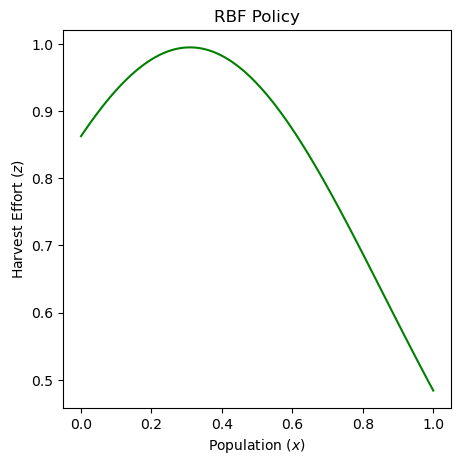

In [3]:
# Set the RBF parameters
nRBFs = 2
RBF_params = [0.2, 1.1, 0.41, 0.34,0.7, 0.59]

# Specify plot ranges
x_range = [0, 1]
x_label = 'Population ($x$)'
y_range = [0,1]
y_label = 'Harvest Effort ($z$)'

# Plot the policy curve
plot_RBF_policy(x_range, x_label, y_range, y_label, RBF_params, nRBFs)

This policy does not make much intuitive sense... why should harvesting efforts be _decreased_ when the fish population is _large_? Well, that's because I chose these RBF parameter values randomly.  

To demonstrate the flexibility of the RBF functions, and the variety of policy functions that can result from them, I generated a few (_n = 7_) policies using a random sample of parameter values. The parameter values were sampled from a uniform distribution over each parameters range: $c_i, b_i, w_i \in [0,1]$. Below is a plot of the resulting random policy functions:

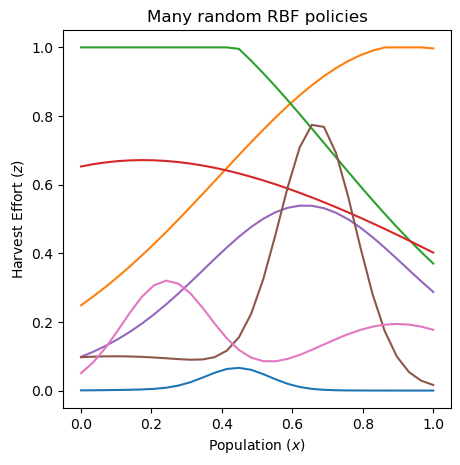

Finding the sets of RBF parameter values that result in Pareto-optimal harvesting policies is the next step in this process!

## Harvest strategy objectives 

We take a multi-objective approach to the generation of a harvesting strategy. Given that the populations are vulnerable to collapse, it is important to consider ecological objectives in the problem formulation. 

Here, we consider five objectives, described below. 

#### Objective 1: Net present value

The net present value is an economic objective corresponding to the amount of fish harvested.  

During the simulation-optimization process (later in this post), we simulate a single policy $N$ times, and take the _average_ objective score over the range of simulations. This method helps to account for variability in expected outcomes due to natural stochasticity. Here, we use $N = 100$ realizations of stochasticity. 

With that in mind, the NPV ($O_1$) is calculated as:
$$O_1 = \frac{1}{N} \sum_{i=1}^N\Big( \sum_{t=0}^T \frac{z_{t+1,i}x_{t,i}}{(1+\delta)^t}\Big)$$

where $\delta$ is the discount rate which converts future benefits to present economic value, here $\delta = 0.05$. 

<br />

#### Objective 2: Prey population deficit

The second objective aims to minimize the average prey population deficit, relative to the prey population carrying capacity, $K$:

$$O_2 = \frac{1}{N} \sum_{i=1}^N\Big( \frac{1}{T} \sum_{t=1}^T \frac{K - x_{t,i}}{K}\Big)$$

<br />

#### Objective 3: Longest duration of consecutive low harvest

In order to maintain steady harvesting levels, we minimize the longest duration of consecutive low harvest. Here, a subjective definition of _low harvest_ is imposed. In a practical decision making process, this threshold may be solicited from the relevant stakeholders. 

Objective #3 is defined as:

$$O_3 = \frac{1}{N} \sum_{i=1}^N(max_T(\phi_{t,i}))$$

where 

$$
\phi_{t,i} = \left\{
	\begin{array}\\
		\phi_{t-1,i} + 1 & \text{if } \ z_t < \text{limit}\\
		0 & \text{otherwise.}
	\end{array}
\right.
$$

And the _low harvest limit_ is: $limit = 5\%$. 

<br />

#### Objective 4: Worst harvest instance

In addition to avoiding long periods of continuously low harvest, the stakeholders have a desire to limit financial risks associated with very low harvests. Here, we minimize the _worst 1%_ of harvest. 

The fourth objective is defined as:

$$O_4 = \frac{1}{N} \sum_{i=1}^N(percentile_T(z_{t+1,i}x_{t,i}, 1))$$

<br />

#### Objective #5: Harvest variance

Lastly, policies which result in low harvest variance are more easily implemented, and can limit corresponding variance in fish populations. 

The last objective minimizes the harvest variance, with the objective score defined as:

$$O_5 = \frac{1}{N} \sum_{i=1}^N(Var_T(z_{t+1,i}x_{t,i}))$$

<br />

#### Constraint: Avoid collapse of predator population

During the optimization process, we are able to include _constraints_ on the harvesting policies. 

Since population collapse is a stable equilibrium point, from which the population will not regrow, it is imperative to consider policies which prevent collapse. 

With this in mind, the policy must not result in _any_ population collapse across the $N$ realizations of environmental stochasticity.  Mathematically, this is enforced by:

$$\frac{1}{N} \sum_{i=1}^N(\Psi_{t,i})) = 0$$

where 

$$
\Psi_{t,i} = \left\{
	\begin{array}\\
		1 & \text{if } \ y_{t,i} < 1\\
		0 & \text{otherwise.}
	\end{array}
\right.
$$

<br />


#### Problem formulation

Given the objectives described above, the optimization problem is: 

$$Minimize \ F(z_x) = (-O_1, O_2, O_3, -O_4, O_5)$$


## Simulation model of the harvested system

Here, I provide an overview of the ```fish_game_5_objs()``` model which combines many of the preceding topics. The goal for this model is to take a set of RBF parameters, which define the harvesting strategy, simulate the policy for some length of time, and then return the objective scores resulting from the policy. 

Later, this model will allow for the optimization of the harvesting policy RBF parameters through a Multi-Objective Evolutionary Algorithm (MOEA). The MOEA will evaluate many thousands of policies (RBF parameter combinations) and attempt to find, through _evolution_, those RBF parameters which yield best objective performance. 

A brief summary of the model process is described here, but the curious learner is encouraged to take a deeper look at the code and dissect the process. 

The model can be understood as having three major sections:
1. Initialization of storage vectors, stochastic variables, and assumed ODE parameters.
2. Simulation of policy and fishery populations over time period T. 
3. Calculation of objective scores. 

In [11]:
def fish_game_5_objs(vars):
    """
    Defines the full, 5-objective fish game problem to be solved

    Parameters
    ----------
    vars : list of floats
        Contains the C, R, W values

    Returns
    -------
    objs, cnstr
    """

    # Get chosen strategy
    strategy = 'Previous_Prey'

    # Define variables for RBFs
    nIn = 1 # no. of inputs (depending on selected strategy)
    nOut = 1 # no. of outputs (depending on selected strategy)
    nRBF = 2 # no. of RBFs to use

    nObjs = 5
    nCnstr = 1 # no. of constraints in output

    tSteps = 100 # no. of timesteps to run the fish game on
    N = 100 # Number of realizations of environmental stochasticity

    # Define assumed system parameters
    a = 0.005
    b = 0.5
    c = 0.5
    d = 0.1
    h = 0.1
    K = 2000
    m = 0.7
    sigmaX = 0.004
    sigmaY = 0.004

    # Initialize storage arrays for populations and harvest
    x = np.zeros(tSteps+1) # Prey population
    y = np.zeros(tSteps+1) # Predator population
    z = np.zeros(tSteps+1) # Harvest effort

    # Create array to store harvest for all realizations
    harvest = np.zeros([N,tSteps+1])
    # Create array to store effort for all realizations
    effort = np.zeros([N,tSteps+1])
    # Create array to store prey for all realizations
    prey = np.zeros([N,tSteps+1])
    # Create array to store predator for all realizations
    predator = np.zeros([N,tSteps+1])

    # Create array to store metrics per realization
    NPV = np.zeros(N)
    cons_low_harv = np.zeros(N)
    harv_1st_pc = np.zeros(N)
    variance = np.zeros(N)

    # Create arrays to store objectives and constraints
    objs = [0.0]*nObjs
    cnstr = [0.0]*nCnstr

    # Create array with environmental stochasticity for prey
    epsilon_prey = np.random.normal(0.0, sigmaX, N)

    # Create array with environmental stochasticity for predator
    epsilon_predator = np.random.normal(0.0, sigmaY, N)

    # Go through N possible realizations
    for i in range(N):

        # Initialize populations and values
        x[0] = prey[i,0] = K
        y[0] = predator[i,0] = 250
        z[0] = effort[i,0] = harvest_strategy([x[0]], vars, [[0, K]], [[0, 1]], nIn, nOut, nRBF)
        NPVharvest = harvest[i,0] = effort[i,0]*x[0]

        # Go through all timesteps for prey, predator, and harvest
        for t in range(tSteps):

            # Solve discretized form of ODE at subsequent time step
            if x[t] > 0 and y[t] > 0:
                x[t+1] = (x[t] + b*x[t]*(1-x[t]/K) - (a*x[t]*y[t])/(np.power(y[t],m)+a*h*x[t]) - z[t]*x[t])* np.exp(epsilon_prey[i]) # Prey growth equation
                y[t+1] = (y[t] + c*a*x[t]*y[t]/(np.power(y[t],m)+a*h*x[t]) - d*y[t]) *np.exp(epsilon_predator[i]) # Predator growth equation

                # Solve for harvesting effort at next timestep
                if t <= tSteps-1:
                    if strategy == 'Previous_Prey':
                        input_ranges = [[0, K]] # Prey pop. range to use for normalization
                        output_ranges = [[0, 1]] # Range to de-normalize harvest to
                        z[t+1] = harvest_strategy([x[t]], vars, input_ranges, output_ranges, nIn, nOut, nRBF)

            # Store values in arrays
            prey[i,t+1] = x[t+1]
            predator[i,t+1] = y[t+1]
            effort[i,t+1] = z[t+1]
            harvest[i,t+1] = z[t+1]*x[t+1]
            NPVharvest = NPVharvest + harvest[i,t+1]*(1+0.05)**(-(t+1))

        # Solve for objectives and constraint
        NPV[i] = NPVharvest
        low_hrv = [harvest[i,j]<prey[i,j]/20 for j in range(len(harvest[i,:]))] # Returns a list of True values when there's harvest below 5%
        count = [ sum( 1 for _ in group ) for key, group in itertools.groupby( low_hrv ) if key ] # Counts groups of True values in a row
        if count: # Checks if theres at least one count (if not, np.max won't work on empty list)
            cons_low_harv[i] = np.max(count)  # Finds the largest number of consecutive low harvests
        else:
            cons_low_harv[i] = 0
        harv_1st_pc[i] = np.percentile(harvest[i,:],1)
        variance[i] = np.var(harvest[i,:])

    # Average objectives across N realizations
    objs[0] = -np.mean(NPV) # Mean NPV for all realizations
    objs[1] = np.mean((K-prey)/K) # Mean prey deficit
    objs[2] = np.mean(cons_low_harv) # Mean worst case of consecutive low harvest across realizations
    objs[3] = -np.mean(harv_1st_pc) # Mean 1st percentile of all harvests
    objs[4] = np.mean(variance) # Mean variance of harvest

    cnstr[0] = np.mean((predator < 1).sum(axis=1)) # Mean number of predator extinction days per realization

    # output should be all the objectives, and constraint
    return objs, cnstr

The next section shows how to optimize the harvest policy defined by ```vars```, using the PyBorg MOEA.

## A (Very) Brief Overview of PyBorg 

PyBorg is the secondary implementation of the Borg MOEA written entirely in Python by David Hadka and Andrew Dircks. It is made possible using functions from the [Platypus optimization library](https://github.com/Project-Platypus/Platypus), which is a Python evolutionary computing framework. 

As PyBorg is Borg's Python wrapper and thus derived from the original Borg MOEA, it can only be used with permission from its creators. To obtain permission for download, please visit [BorgMOEA](http://borgmoea.org/#contact) and complete the web form. You should receive an email with the link to the BitBucket repository shortly.

## Installation
The repository you have access to should be named 'Serial Borg MOEA' and contain a number of folders, including one called `Python/`. Within the `Python/` folder, you will be able to locate a folder called `pyborg`. Once you have identified the folder, please follow these next steps carefully:<br>
1. Check your current Python version. *Python 3.5 or later is required to enable PyBorg implementation*. 
2. Download the `pyborg` folder and place it in the folder where this Jupyter Notebook all other Part 1 training material is located. 
3. Install the `platypus` library. This can be in done via your command line by running one of two options: <br>
If you are using `pip`
```
pip install platypus-opt
```
    If you are using `conda`
```
conda config --add channels conda-forge
conda install platypus-opt
```
4. Make sure the following training startup files are located within the same folder as this Jupyter Notebook:
    a) `fish_game_functions.py`: Contains all function definitions to setup the problem, run the optimization, plot the hypervolume, and conduct random seed analysis.
    b) `Part 1 - Harvest Optimization and MOEA Diagnostics.ipynb`: This is the current notebook and where the Fisheries fame will be demonstrated.
    
We are now ready to proceed!

## Optimization of the Fisheries Game
### Import all libraries
All functions required for this post can be found in the `fish_game_functions.py` file. This code is adapted from [Antonia Hadjimichael's original post](https://waterprogramming.wordpress.com/2021/08/13/introduction-to-pyborg-basic-setup-and-running/) on exploring the Fisheries Game dynamics using PyBorg.

In [4]:
# import all required libraries
from platypus import Problem, Real, Hypervolume, Generator
from pyborg import BorgMOEA
from fish_game_functions import *
from platypus import Problem, Real, Hypervolume, Generator
from pyborg import BorgMOEA
import time
import random

### Formulating the problem

Define number of decision variables, constraints, and specify problem formulation:

In [5]:
# Set the number of decision variables, constraints and performance objectives
nVars = 6   # Define number of decision variables
nObjs = 5   # Define number of objectives
nCnstr = 1      # Define number of decision constraints

# Define the upper and lower bounds of the performance objectives
objs_lower_bounds = [-6000, 0, 0, -250, 0]
objs_upper_bounds = [0, 1, 100, 0, 32000]

### Initialize the problem for optimization
We call the `fisheries_game_problem_setup.py` function to set up the optimization problem. This function returns a PyBorg object called `algorithm` in this exercise that will be optimized in the next step.<br>

In [12]:
def fisheries_game_problem_setup(nVars, nObjs, nCnstr, pop_size=100):
    """
    Sets up and runs the fisheries game for a given population size

    Parameters
    ----------
    nVars : int
        Number of decision variables.
    nObjs : int
        Number of performance objectives.
    nCnstr : int
        Number of constraints.
    pop_size : int, optional
        Initial population size of the randomly-generated set of solutions.
        The default is 100.

    Returns
    -------
    algorithm : pyBorg object
        The algorthm to optimize with a unique initial population size.

    """
    # Set up the problem
    problem = Problem(nVars, nObjs, nCnstr)
    nVars = 6   # Define number of decision variables
    nObjs = 5   # Define number of objective -- USER DEFINED
    nCnstr = 1      # Define number of decision constraints

    problem = Problem(nVars, nObjs, nCnstr)

    # set bounds for each decision variable
    problem.types[0] = Real(0.0, 1.0)
    problem.types[1] = Real(0.0, 1.0)
    problem.types[2] = Real(0.0, 1.0)
    problem.types[3] = Real(0.0, 1.0)
    problem.types[4] = Real(0.0, 1.0)
    problem.types[5] = Real(0.0, 1.0)

    # all values should be nonzero
    problem.constraints[:] = "==0"

    # set problem function
    if nObjs == 5:
        problem.function = fish_game_5_objs
    else:
        problem.function = fish_game_3_objs

    algorithm = BorgMOEA(problem, epsilons=0.001, population_size=pop_size)
    return algorithm

In [13]:
# initialize the optimization
algorithm = fisheries_game_problem_setup(nVars, nObjs, nCnstr)

### Define parameters for optimization
Before optimizing, we have to define our desired population size and number of function evaluations (NFEs). The NFEs correspond to the number of _evolutions_ of the set of solutions. For complex, many-objective problems, it may be necessary for a large NFE.  

Here, we start with a small limit on NFE, to test the speed of the optimization. Limiting the optimization to 100 NFE is going to produce relatively poor performing solutions, however it is a good starting point for our diagnostic tests. 

In [14]:
init_nfe = 100
init_pop_size = 100

### Begin the optimization
In addition to running the optimization, we also time the optimization to get a general estimate on the time the full hypervolume analysis will require.

In [24]:
# begin timing the Borg run
borg_start_time = time.time()

algorithm = fisheries_game_problem_setup(nVars, nObjs, nCnstr, pop_size=int(init_pop_size))
algorithm.run(int(init_nfe))

# end timing and print optimization time 
borg_end_time = time.time()

borg_total_time = borg_end_time - borg_start_time

print(f"borg_total_time={borg_total_time}s")

borg_total_time=33.62936472892761s


> **NOTICE:**
> Running the PyBrog MOEA 100 times took ~34 seconds (on the machine which this was written on...).  Keep this in mind, that increasing the NFE will require correspondingly more time. If you increase the number too much, your machine may take a long time to compute the final Pareto-fornt. 

### Plot the tradeoff surface

Here, we plot a 3-dimensional plot showing the tradeoff between a select number of objectives. If you have selected the 5-objective problem formulation, you should select the three objectives you would like to analyze the tradeoff surface for. Please select the (abbreviated) objective names from the following list:<br>

*Objective 1: Mean NPV<br>
Objective 2: Mean prey deficit<br>
Objective 3: Mean WCLH<br>
Objective 4: Mean 1% harvest<br>
Objective 5: Mean harvest variance<br>*

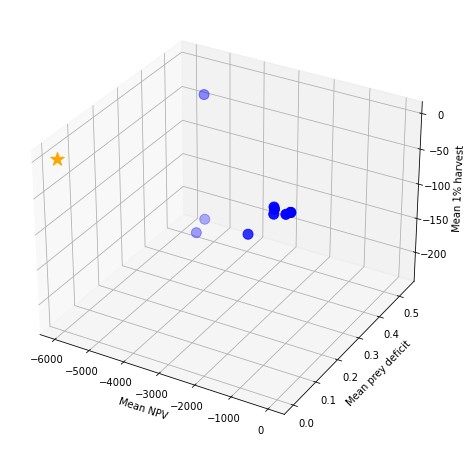

In [16]:
# Plot objective tradeoff surface
fig_objs = plt.figure(figsize=(8,8))
ax_objs = fig_objs.add_subplot(111, projection='3d')

# Select the objectives to plot from the list provided in the description above
obj1 = 'Mean NPV'
obj2 = 'Mean prey deficit'
obj3 = 'Mean 1% harvest'

plot_3d_tradeoff(algorithm, ax_objs, nObjs, obj1, obj2, obj3)

The objectives scores arn't very good, but that is because the number of function evaluations is so low. In order to get a better set of solutions, we need to run the MOEA for many function evaluations.  

The next section demonstrates the change in objective performance with respect to the number of function evaluations.


## MOEA Diagnostics
A good MOEA is assessed by it's ability to quickly converge to a set of solutions (the Pareto-approximate set) that is also diverse. This means that the final set of solutions is close to the true set, as well as covers a large volume of the multi-dimensional problem space. There are three quantitative metrics via which convergence and diversity are evaluated:
1. *Generational distance* approximates the average distance between the true Pareto front and the Pareto-approximate reference set that your MOEA identifies. It is the easiest metric to meet.
2. *Epsilon indicator* is a harder metric than generational distance to me   et. A high-performing MOEA will have a low epsilon indicator value when the distance of its worst-performing approximate solution from the true Pareto set is small.
3. *Hypervolume* measures the 'volume' that a Pareto front covers across all dimensions of a problem. It is the hardest metric to meet and the most computationally intensive. 

Both the generational distance and epsilon indicator metrics require a reference set, which is the *known*, true Pareto front. Conversely, the hypervolume does not have such a requirement. Given that the Fisheries Game is a complex, multi-dimensional, many-stakeholder problem with no known solution, the hypervolume metric is thus the most suitable to evaluate the ability of PyBorg to quickly converge to a diverse Pareto-approximate set of solutions.

More detailed descriptions of each metric are provided in [this handy blog post by Joe Kasprzyk](https://waterprogramming.wordpress.com/2013/06/25/moea-performance-metrics/).

### Hypervolume
The hypervolume is a measure of the multi-dimensional volume _dominated_ by the approximated pareto front. As the pareto front advances toward the "_ideal_" solution, this value approaches 1. 

The efficiency of an MOEA in optimizing a solution can be considered by measuring the hypervolume with respect to the number of function evaluations. This allows the user to understand how quickly the MOEA is converging to a good set of solutions, and how many function evaluations are needed to achieve a good set of solutions.

#### Defining hypervolume parameters
First, we define the maximum number of function evaluations (`maxevals`) and the NFE step size (`frequency`) for which we would like to evaluate the problem hypervolume over. Try modifying these values to see how the plot changes. <br>
<br>

Mind that the value of `maxevals` should always be more than that of your initial NFE, and that the value of `frequency` should be less than that of the initial NFE. Both values should be integer values.

Also be mindful that increasing the ```maxevals``` > 1000 is going to result in long runtimes. 

In [25]:
maxevals = 500
frequency = 100

#### Plotting the hypervolume
Using these parameters, we then plot the hypervolume graph, showing the change in hypervolume value over the NFEs. 

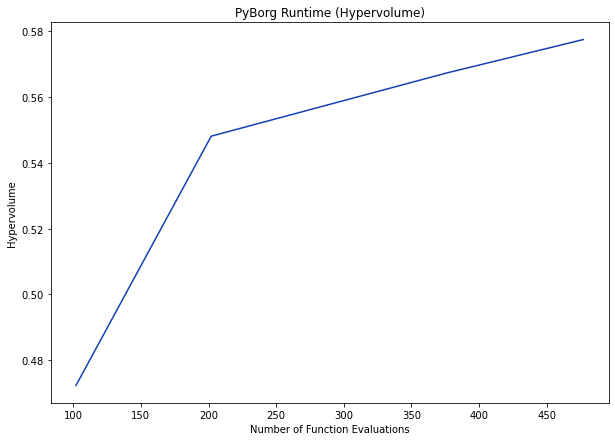

In [26]:
fig_hvol = plt.figure(figsize=(10,7))
ax_hvol = fig_hvol.add_subplot()

plot_hvol(algorithm, maxevals, frequency, objs_lower_bounds, objs_upper_bounds, ax_hvol)

plt.title('PyBorg Runtime (Hypervolume)')
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Hypervolume')
plt.show()

#### Perform random seed analysis 
Next, we perform random seed analysis (RSA).<br>

Generally, RSA is performed to track an algorithm's performance during search. In addition, it is also done to determine if an algorithm has discovered an acceptable approximation of the true Pareto set. More details on RSA can be found [here](https://waterprogramming.wordpress.com/2019/04/17/performing-random-seed-analysis-and-runtime-diagnostics-with-the-serial-borg-matlab-wrapper/) in a blog post by Dave Gold.<br>

For the Fisheries Game, we conduct RSA to determine if PyBorg's performance is sensitive to the size of its initial population. We do this using the folllowing steps:
1. Run an ensemble of searches, each starting with a randomly sampled set of initial conditions (aka “random seeds”)
2. Combine search results across all random seeds to generate a “reference set” that contains only the best non-dominated solutions across the ensemble
3. Repeat steps 1 and 2 for an initial population size of 200, 400, etc.

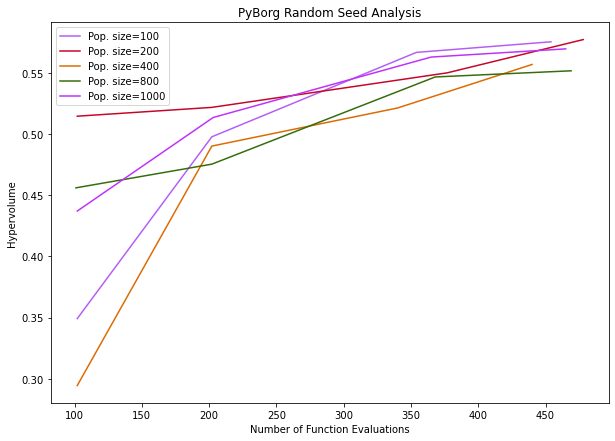

In [19]:
pop_size_list = [100, 200, 400, 800, 1000]

fig_rand_seed = plt.figure(figsize=(10,7))
ax_rand_seed = fig_rand_seed.add_subplot()

for p in range(len(pop_size_list)):
    fisheries_game_problem_setup(nVars, nObjs, nCnstr, pop_size_list[p])
    algorithm = fisheries_game_problem_setup(nVars, nObjs, nCnstr, pop_size=int(init_pop_size))
    algorithm.run(int(init_nfe))
    
    plot_hvol(algorithm, maxevals, frequency, objs_lower_bounds, objs_upper_bounds, 
              ax_rand_seed, pop_size_list[p])

plt.title('PyBorg Random Seed Analysis')
plt.xlabel('Number of Function Evaluations')
plt.ylabel('Hypervolume')
plt.legend()
plt.show()

Notice that the runs performed with different initial population sizes tend to converge toward a similar hypervolume value after 500 NFEs.  

This reveals that the PyBorg MOEA is not very sensitive to the specific initial parameters; it is adaptable enough to succeed under different configurations.

## Conclusion

A classic decision-making idiom says 'defining the problem is the problem'. Hopefully, this post has revealed that to be true; we have shown that changes to the harvesting strategy functions, simulation model, or objective scores can result in changes to the resulting outcomes.

And if you've made it this far, congratulations! Take a minute to think back on the progression of this post: we revisited the harvested predator-prey model, formulated the harvesting policy using RBFs, and formulated the policy objectives and its associated simulation model. Next, we optimized the harvesting policy using the PyBorg MOEA and performed basic MOEA diagnostics using hypervolume as our measure, and executed random seed analysis.

If you've progressed through this tutorial using the Jupyter Notebook, we encourage you to re-visit the source code involved in this process. The next advisable step is to re-produce this problem from scratch, as this is the best way to develop a detailed understanding of the process.

**Next time**, we will explore the outcomes of this optimization, by considering the tradeoffs present across the Pareto set of solutions.  

Till then, thanks for reading!